In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Load TFLite model and allocate tensors.
#interpreter = tf.lite.Interpreter(model_path="yolov5.tflite")
interpreter = tf.lite.Interpreter(model_path="yolov8_float32_cats_dogs.tflite")
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

classes = [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]

classes = [ 'cat','dog' ]

In [4]:
input_shape = input_details[0]['shape']
input_shape

array([  1, 640, 640,   3], dtype=int32)

In [5]:
output_details

[{'name': 'Identity',
  'index': 409,
  'shape': array([   1,    6, 8400], dtype=int32),
  'shape_signature': array([   1,    6, 8400], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

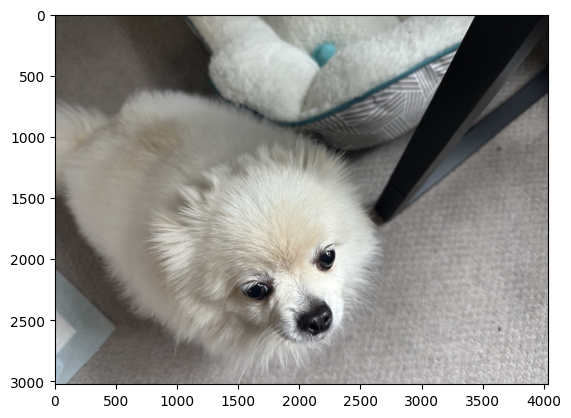

In [6]:
#img = Image.open('table.jpg')
img = Image.open('images/IMG_9171.jpeg')

data = np.array(img.resize(input_shape[1:3],Image.Resampling.LANCZOS), dtype=np.float32)
data /= 255.0
data = data[np.newaxis,...]
plt.imshow(img)

In [7]:
interpreter.set_tensor(input_details[0]['index'], data)
interpreter.invoke()


In [8]:
result = interpreter.get_tensor(output_details[0]['index']).squeeze(0).T
boxes = result[...,0:4]
boxes[...,0]*= img.width
boxes[...,1]*= img.height
boxes[...,2]*= img.width
boxes[...,3]*= img.height
scores = np.max(result[...,4:6].squeeze(), axis=1)

In [9]:
selected = tf.image.non_max_suppression(
    boxes,
    scores,
    100,
    iou_threshold=0.2,
    score_threshold=0.4
)

2024-05-21 15:42:29.799224: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-05-21 15:42:29.799244: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-05-21 15:42:29.799249: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-05-21 15:42:29.799269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-21 15:42:29.799280: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
for ix in selected:
    res = result[ix,:]
    xywh = boxes[ix,:4]
    conf = res[5:]*res[4:5]
    clas = np.argmax(res[4:6],axis=0)
    print(xywh, res[4+clas], clas, classes[clas])

[1449.0997 1701.345  2814.2383 2569.702 ] 0.6462601 1 dog


[1449.0997 1701.345  2814.2383 2569.702 ] 0.6462601 1 dog


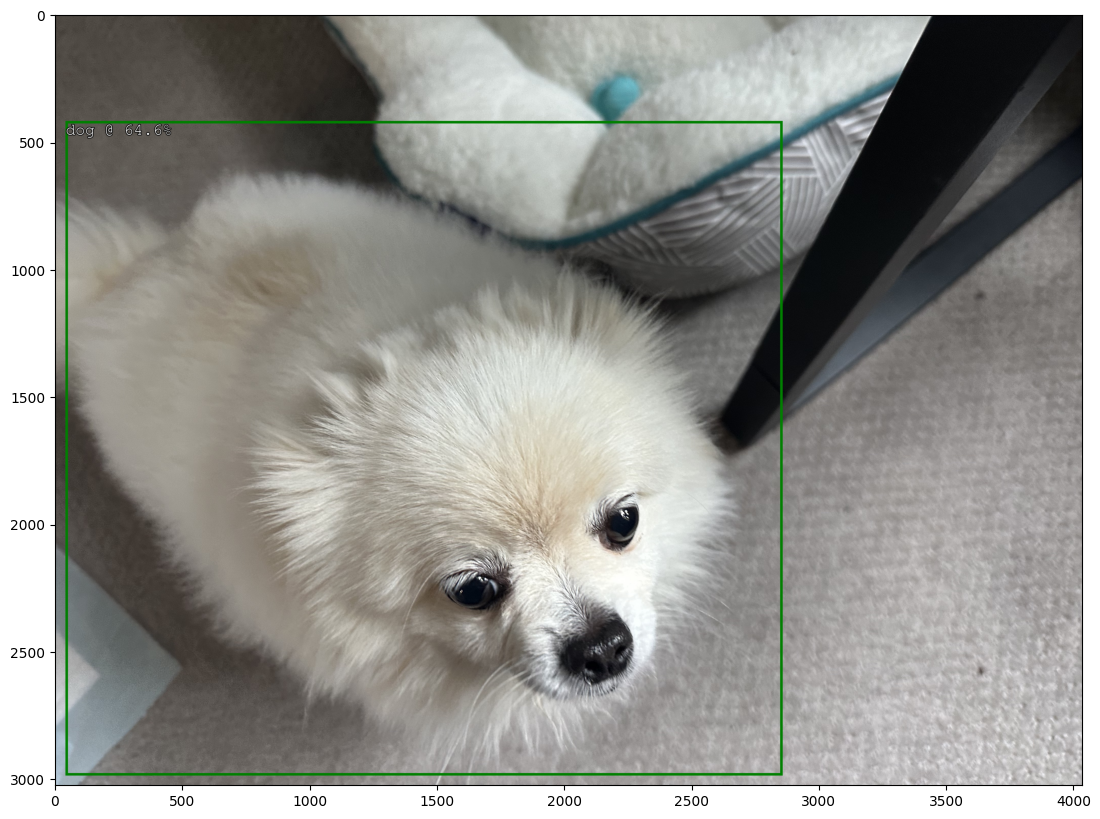

In [11]:
draw_img = img.copy()
drawing = ImageDraw.Draw(draw_img)
f = ImageFont.truetype('Courier New.ttf',64)

for ix in selected:
    res = result[ix,:]
    xywh = boxes[ix,:4]
    clas = np.argmax(res[4:6],axis=0)
    print(xywh, res[4+clas], clas, classes[clas]) 
    drawing.rectangle([xywh[0]-xywh[2]/2,xywh[1]-xywh[3]/2, xywh[0]+xywh[2]/2, xywh[1]+xywh[3]/2],
                      outline='green',width=10)
    drawing.text([xywh[0]-xywh[2]/2,xywh[1]-xywh[3]/2],fill='white', 
                 stroke_width=3, stroke_fill='black',font=f,  text=f'{classes[clas]} @ {res[4+clas]*100:.1f}%')
plt.figure(figsize=(14,10))
plt.imshow(draw_img)